# Final Tutorial - Global Terrorism Data Analysis
### Brian Lee and Nick Shinn

## Introduction

In this tutorial, you will apply data science to explore correlations that exist within global terrorism data, using the Global Terrorism Database maintained by the START consortium. We will first visualize the global data in various ways to form a better intuition on possible correlations that may exist. Using compiled features such as date and location, we will hypothesize what related factors may play a role in determining the likelihood of a terrorist attack and cross reference data outside the original dataset to test our hypotheses. (statistical Analysis blah blah)

We will be using mushroom data provided by UC Irvine to train our machine learning algorithms, and rely heavily on the python toolkit scikit-learn. The tutorial will walk through the process of creating decision trees and support vector machines for a binary classification given categorical features, which often makes analysis slightly more difficult.
While mushrooms are not often life-threatening or life-changing, these supervised learning algorithms are applicable to almost any classification problem. And, of course, this isn't to say that mushrooms aren't ever life-changing.

## Getting Started
Before you begin, you will need to install a few libraries. First, confirm you have the python package manager 'pip' installed on your computer. Installation instructions can be found online.

You may find the Global Terrorism Database at https://www.kaggle.com/START-UMD/gtd or access it directly through this git repository in the Datasets/Terrorism/ directory. The version in the repository is modified to only include the data from 1990 onwards as the total file exceeds the file size limit.

### Installing Packages
Before beginning you must install all required packages:
- numpy 
- matplotlib
- pandas
- folium
- seaborn
- sklearn
- statsmodels

If any are missing you may install them through your computer's shell or directly through this tutorial using the script below.

In [2]:
%%capture
import pip
def install(package):
   pip.main(['install', package])

install('numpy')
install('matplotlib')
install('pandas')
install('folium')
install('seabord')
install('sklearn')
install('statsmodels')

### Importing Packages
Now that we have the packages we need we can import and alias them for this tutorial

In [3]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import csv, folium
from datetime import datetime
from folium.plugins import HeatMapWithTime
%matplotlib inline

# I. Data Collection and Processing
## Cleaning
We want to pull in our global terrorism data as a pandas dataframe to begin

In [93]:
gtd_table = pd.read_csv("./Datasets/Terrorism/gtd_30cols.csv", encoding='latin1', low_memory=False)
gtd_table.head()

,Unnamed: 0,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,...,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt
0,0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,...,1,1,0,NaN,NaN,0,1,0,1,Assassination
1,1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,...,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping)
2,2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,...,1,1,0,NaN,NaN,0,1,0,1,Assassination
3,3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,...,1,1,0,NaN,NaN,0,1,0,3,Bombing/Explosion
4,4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,...,1,1,-9,NaN,NaN,0,1,0,7,Facility/Infrastructure Attack


### Selecting Desired Columns

The columns we are interested in looking at are the ones containing time and location data. We'll save the eventid and attacktype1 along with the time/location columns in case we find a need for it later. Once we've selected our columns we'll rename them for readability.

In [94]:
# Retrieve desirable columns
column_names = ['eventid', 'iyear', 'imonth', 'iday', 'country_txt', 'provstate', 'city', 'latitude', 'longitude', 'attacktype1_txt']
gtd_table = gtd_table[column_names]

# Rename columns
new_column_names = ['id', 'year', 'month', 'day', 'country', 'provstate', 'city', 'latitude', 'longitude', 'attacktype']
gtd_table.columns = new_column_names

### Modifying Faulty Entries

In [95]:
gtd_table.describe()

,id,year,month,day,latitude,longitude
count,1.703500e+05,170350.000000,170350.000000,170350.000000,165744.000000,165744.000000
mean,2.001776e+11,2001.709997,6.474365,15.466845,23.399774,26.350909
std,1.314444e+09,13.144146,3.392364,8.817929,18.844885,58.570068
min,1.970000e+11,1970.000000,0.000000,0.000000,-53.154613,-176.176447
25%,1.990053e+11,1990.000000,4.000000,8.000000,11.263580,2.396199
50%,2.007121e+11,2007.000000,6.000000,15.000000,31.472680,43.130000
75%,2.014023e+11,2014.000000,9.000000,23.000000,34.744167,68.451297
max,2.017013e+11,2016.000000,12.000000,31.000000,74.633553,179.366667


Looking at the table above we see that there are entries where the month, day, or both are logged as 0. Upon inspection we see see that when either descriptor is 0 the associated entry is either incomplete or an attack that spanned multiple days. Since either scenario can be unreliable for temporal data analysis, we will drop any rows containing a 0 in either column.

In [96]:
gtd_table = gtd_table[gtd_table.month != 0]
gtd_table = gtd_table[gtd_table.day != 0]
gtd_table = gtd_table.reset_index(drop=True)

The other column we would like to have is a date column that has the collective year-month of an event so that we can more easily create generate a graphp grouped by this column

In [97]:
gtd_table['date'] = gtd_table.apply(lambda row: '%d-%02d' %(row.year, row.month), axis=1)

Now, there are two additional columns we want to create to make our exploratory analysis easier. The first is a column indicating the day of the year that the event occured. Using this we can more easily generate time-dependent imaging of the occurence of events. We save this value as a single integer.

In [101]:
# Converting year, month, day columns to days of year
daysofyear = []
months = []
days = []
for index,row in gtd_table.iterrows():
    year = row['year']
    month = row['month']
    day = row['day']
    daysofyear.append(datetime(year,month,day).timetuple().tm_yday)
    months.append(month)
    days.append(day)
gtd_table['dayofyear'] = daysofyear
gtd_table.head()

,id,year,month,day,country,provstate,city,latitude,longitude,attacktype,date,dayofyear
0,197000000001,1970,7,2,Dominican Republic,NaN,Santo Domingo,18.456792,-69.951164,Assassination,1970-07,183
1,197001010002,1970,1,1,United States,Illinois,Cairo,37.005105,-89.176269,Armed Assault,1970-01,1
2,197001020001,1970,1,2,Uruguay,Montevideo,Montevideo,-34.891151,-56.187214,Assassination,1970-01,2
3,197001020002,1970,1,2,United States,California,Oakland,37.805065,-122.273024,Bombing/Explosion,1970-01,2
4,197001020003,1970,1,2,United States,Wisconsin,Madison,43.076592,-89.412488,Facility/Infrastructure Attack,1970-01,2


# II. Exploratory Data Analysis and Visualization

## Temporal Data

### Chronological Counts by Month

Now that we have our desired columns let's take a look at the occurences of global terrorist attacks by month.

In [150]:
# Group table by date into counts
glo_chm = gtd_table[['date','id']].groupby(['date']).count()
glo_chm = glo_chm.rename(index=str, columns={'id':'count'})
glo_chm = glo_chm.reset_index()
glo_chm.head()

,date,count
0,1970-01,36
1,1970-02,55
2,1970-03,68
3,1970-04,78
4,1970-05,70


We'll first want to establish some properly spaced labels from the data we have in order ot make our graph more readable. Then we can generate our graph.

In [151]:
# Establish ticks and labels for this type of graph
yearmax = gtd_table['year'].max()
yearmin = gtd_table['year'].min()
numyears = yearmax - yearmin + 1
year_labels = range(yearmin, yearmax+1, 5)
year_ticks = [60*i for i in range(int(numyears/5)+1)]

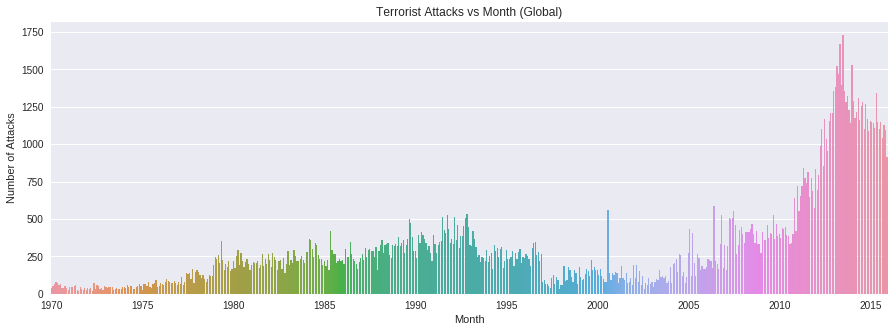

In [149]:
# Graph and label figure
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x='date',y='count',data=glo_chm)
plt.title('Terrorist Attacks vs Month (Global)')
plt.ylabel('Number of Attacks')
plt.xlabel('Month')
plt.xticks(year_ticks);
ax.set_xticklabels(year_labels);

From our graph we can see that there was a clear spike in the logging of global terrorist activity around the early 2000's. This can either be indicative of an increase in terrorist activity, most likely incited by a specific movement or group. 

Another pattern we notice is what seems to be a lull in terrorist activity between the late 1990's and mid-2000's. Activity then ramps up drastically at the turn of this decade. Is there really such a sharp difference in terrorist activity between the years? What metrics are being used to qualify the incident as a terrorist attack? Perhaps it's the classification or rate of successful logging for terrorist activity that has changed rather than the act itself.  

### Chronological Counts by Year

Let's try organizing the chronological data of attacks by year rather than month to make our visualization easier to understand.

In [152]:
# Group table by date into counts
glo_chy = gtd_table[['year','id']].groupby(['year']).count()
glo_chy = glo_chy.rename(index=str, columns={'id':'count'})
glo_chy = glo_chy.reset_index()
glo_chy.head()

,year,count
0,1970,636
1,1971,460
2,1972,489
3,1973,463
4,1974,571


In [153]:
# Establish ticks and labels for this type of graph
year_labels2 = range(yearmin, yearmax+1, 5)
year_ticks2 = [5*i for i in range(int(numyears/5)+1)]

We'll first want to establish some properly spaced labels from the data we have in order ot make our graph more readable. Then we can generate our graph.

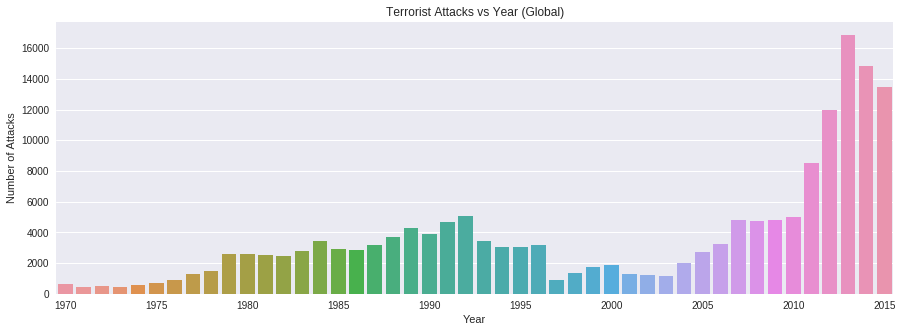

In [154]:
# Graph and label figure
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x='year',y='count',data=glo_chy)
plt.title('Terrorist Attacks vs Year (Global)')
plt.ylabel('Number of Attacks')
plt.xlabel('Year')
plt.xticks(year_ticks2);
ax.set_xticklabels(year_labels2);

### Counts by Day of the Year

Now let's generate a graph using our day of the year column. We can check for any trends in activity throughout the year.

In [155]:
table_by_date = gtd_table[['dayofyear','id']].groupby(['dayofyear']).count()
table_by_date = table_by_date.rename(index=str, columns={'id':'count'})
table_by_date = table_by_date.reset_index()
table_by_date.head()

,dayofyear,count
0,1,584
1,2,388
2,3,496
3,4,496
4,5,421


Like before, we want to generate some appropriate markers for our x-axis. Otherwise the data will be difficult to read.

In [156]:
month_labels = ['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
month_ticks = []
for i in range(12):
    month_ticks.append(datetime(2000,i+1,1).timetuple().tm_yday)

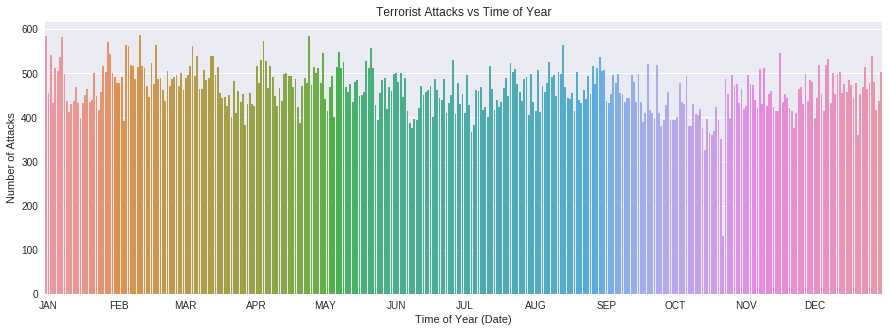

In [114]:
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x='dayofyear',y='count',data=table_by_date);
plt.title('Terrorist Attacks vs Time of Year')
plt.ylabel('Number of Attacks')
plt.xlabel('Time of Year (Date)')
plt.xticks(month_ticks);
ax.set_xticklabels(month_labels);

This time we see a clear difference in counts of terrorist data on certain days of the year. Based on the size of the dataset, we cannot explain this as coincidence. The discrepancy in number of attacks should be correlated to one of the features in our original database or data that can be gained online. One hypothesis we could test is that the spikes in activity are associated with special events throughout the year. Perhaps religious holidays that incite activity from radical groups?

## Stratifying by Country

Every day is a holiday somewhere. In order to draw a more meaningful correlation we could try narrowing down our analysis to a single country. Since the U.S. seems to have the largest dataset of reported terrorist attacks we can focus on it as well as the national and religious holidays observed in the country.

We'll start with the chronological data as before, this time grouping the analysis by year from the start since the data is easier to interpret.

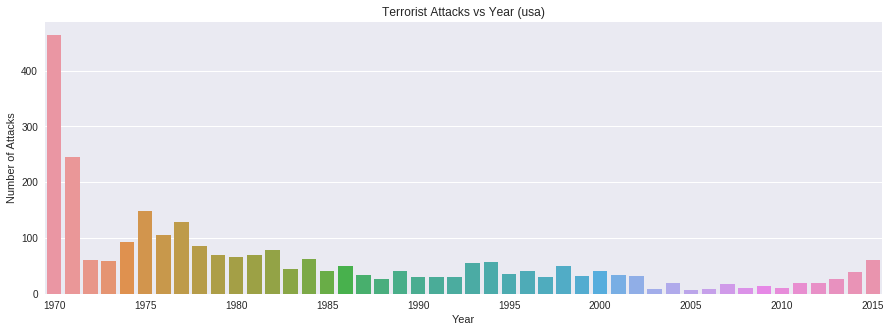

In [162]:
# Group table by date into counts
usa_chy = gtd_table.loc[gtd_table['country'] == 'United States']
usa_chy = usa_chy[['year','id']].groupby(['year']).count()
usa_chy = usa_chy.rename(index=str, columns={'id':'count'})
usa_chy = usa_chy.reset_index()

# Graph and label figure
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x='year',y='count',data=usa_chy)
plt.title('Terrorist Attacks vs Year (usa)')
plt.ylabel('Number of Attacks')
plt.xlabel('Year')
plt.xticks(year_ticks2);
ax.set_xticklabels(year_labels2);

This is... odd. The global trend sees an overall uptrend in terrorist activity whereas the United states sees a downtrend since the '70s. There are several factors that could explain this.

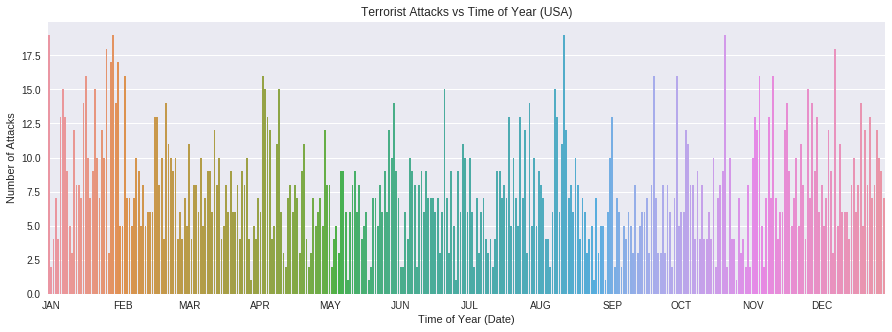

In [119]:
table_by_date = table_usa[['dayofyear','id']].groupby(['dayofyear']).count()
table_by_date = table_by_date.rename(index=str, columns={'id':'count'})
table_by_date = table_by_date.reset_index()
table_by_date.head()

# plot the data
fig, ax = plt.subplots(figsize=(15,5))
sns.barplot(x='dayofyear',y='count',data=table_by_date);
plt.title('Terrorist Attacks vs Time of Year (USA)')
plt.ylabel('Number of Attacks')
plt.xlabel('Time of Year (Date)')
plt.xticks(month_ticks);
ax.set_xticklabels(month_labels);

# IV. Insight and Conclusion

Due to a lot of lat minute pivoting we 